In [1]:
from model import *
import mesa
import pandas as pd
import seaborn as sns
import time as time
import tqdm as tqdm

In [3]:
# Run model
begintime = time.time()

model = HousingMarket()
model.run_model(1000)
data = model.datacollector.get_agent_vars_dataframe()

print(time.time() - begintime)

9.04596471786499


In [5]:
ages = []
        
for k in range(len(data["Age"][1])):

    ages.append(data["Age"].iloc[k])

<AxesSubplot:ylabel='Count'>

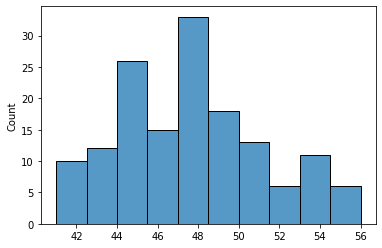

In [6]:
sns.histplot(ages)

In [93]:
dataframe = []
dataframe.append(['trial', 1, 100, 200, 300, 400, 500,
                                     600, 700, 800, 900, 1000])

In [95]:
dataframe = []
dataframe.append(['trial', 1, 100, 200, 300, 400, 500,
                                     600, 700, 800, 900, 1000])

for i in tqdm.tqdm(range(1,31)):
    model = HousingMarket()
    model.run_model(1000)
    data = model.datacollector.get_agent_vars_dataframe()
    
    
    meanages = []
    meanages.append(i)
    
    for j in [1,100,200,300,400,500,600,700,800,900,1000]:
        ages = []
        
        for k in range(len(data["Age"][j])):
            
            ages.append(data["Age"].iloc[k])
        

        meanages.append(np.nanmean(ages))

    dataframe.append(meanages)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:44<00:00,  5.48s/it]


In [96]:
dataframe

[['trial', 1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 [1,
  53.413333333333334,
  53.413333333333334,
  53.413333333333334,
  53.308724832214764,
  53.413333333333334,
  53.413333333333334,
  53.398648648648646,
  53.413333333333334,
  53.413333333333334,
  53.413333333333334,
  53.413333333333334],
 [2,
  52.39333333333333,
  52.39333333333333,
  52.39333333333333,
  52.2312925170068,
  52.39333333333333,
  52.39333333333333,
  52.2312925170068,
  52.39333333333333,
  52.39333333333333,
  52.3445945945946,
  52.39333333333333],
 [3,
  56.2,
  56.2,
  56.2,
  55.83108108108108,
  56.2,
  56.2,
  55.821917808219176,
  56.2,
  56.2,
  55.83108108108108,
  56.2],
 [4,
  52.653333333333336,
  52.653333333333336,
  52.653333333333336,
  52.653333333333336,
  52.653333333333336,
  52.653333333333336,
  52.37162162162162,
  52.653333333333336,
  52.653333333333336,
  52.37241379310345,
  52.653333333333336],
 [5,
  53.34,
  53.34,
  53.34,
  53.304054054054056,
  53.34,
  53.34,
